In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [2]:
from scipy.optimize import curve_fit


def f(t, a, b):
    return a * np.exp(b * t)

In [28]:
def graph_convergence(ax, algo_name, data, logscale, verbose=False, calc_gain=True):
    if verbose:
        print(f"*** Convergence of each param for {algo_name}")
        for c in range(data.shape[-1]):
            vars_popt, vars_pcov = curve_fit(f, data.index, data[c])
            print(
                f"{algo_name} PARAM: {c} -- Scale Factor: {vars_popt[0]}, Rate of Convergence: {vars_popt[1]}"
            )
        print()

    line_palette = ["r", "skyblue", "steelblue", "teal", "navy"]
    res = sns.lineplot(ax=ax, data=data, marker="o", lw=3, palette=line_palette)
    if logscale:
        res.set(xscale='log', yscale='log')
    ax.set_title(f"{algo_name}", fontsize=20)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.get_legend().remove()

    return ax

In [29]:
def simulate_algo(ax, algo_name="Fisher", logscale=False, calc_gain=True):
    org_distr = pd.read_csv(f"../data/{algo_name}_distr.csv")
    rand_distr = pd.read_csv(f"../data/Random_distr.csv") if calc_gain else None
    
    
    org_distr["diffs"] = org_distr["diffs"].apply(
        lambda x: np.fromstring(
            x.replace("\n", "").replace("[", "").replace("]", "").replace("  ", " "),
            sep=" ",
        )
    )
    
    if calc_gain:
        rand_distr["diffs"] = rand_distr["diffs"].apply(
            lambda x: np.fromstring(
                x.replace("\n", "").replace("[", "").replace("]", "").replace("  ", " "),
                sep=" ",
            )
        )
     
    
    variances = []
    gains = []
    grouped = org_distr.groupby(["Iteration"])
    for (name, group) in grouped:
        diffs = group["diffs"]
        
        if calc_gain:
            rand_diffs = rand_distr[rand_distr.Iteration == name]['diffs']
            algo_var = np.var(np.array(diffs),axis=0)
            rand_var = np.var(np.array(rand_diffs), axis=0)
            gains.append(rand_var / algo_var)
        else:
            variances.append(np.var(np.array(diffs), axis=0))
    
    variances_df = pd.DataFrame(variances)
    gains_df = pd.DataFrame(gains)
    return graph_convergence(ax, algo_name, data=gains_df if calc_gain else variances_df, logscale=logscale, calc_gain=calc_gain)

In [30]:
from collections import OrderedDict


def plot_sims(logscale=False, calc_gain = True):
    figsz = (25, 6)
    algos = ["Fisher"] # , "BAIT", "CoreSet"
    if calc_gain:
        algos.append("Random")
    fig, axes = plt.subplots(1, len(algos), figsize=figsz, sharex=True, sharey=True)
    fig.suptitle(
        f"{'Gain Ratio' if calc_gain else 'Variance'} of Parameters on LinReg Model ({'higher' if calc_gain else 'lower'} is better)\n",
        size=30,
        y=1.12,
    )
    y_label = r"Gain Ratio ($\frac{Var_{random}}{Var_{algo}}$)" if calc_gain else r"Variance($\beta$-hat - $\beta$_true)"

    fig.supylabel(y_label, size=20, x=0.07)
    fig.supxlabel("Iteration", size=20)

    for ax_indx, algo in enumerate(algos):
        simulate_algo(axes[ax_indx], algo, logscale, calc_gain=calc_gain)

    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [r"$\beta_" + str(l) + r"$" for l in labels]
    by_label = OrderedDict(zip(labels, handles))
    legend = fig.legend(
        by_label.values(),
        by_label.keys(),
        prop={"size": 20},
        bbox_to_anchor=(0.15, -0.2, 0.7, 0.102),
        ncol=2,#5,
        loc="lower left",
        mode="expand",
        borderaxespad=0.0,
    )
    legend.set_title("Parameters", prop={"size": 20})

    for i in range(len(labels)):
        legend.legend_handles[i].set_linewidth(6)

TypeError: 'Axes' object is not subscriptable

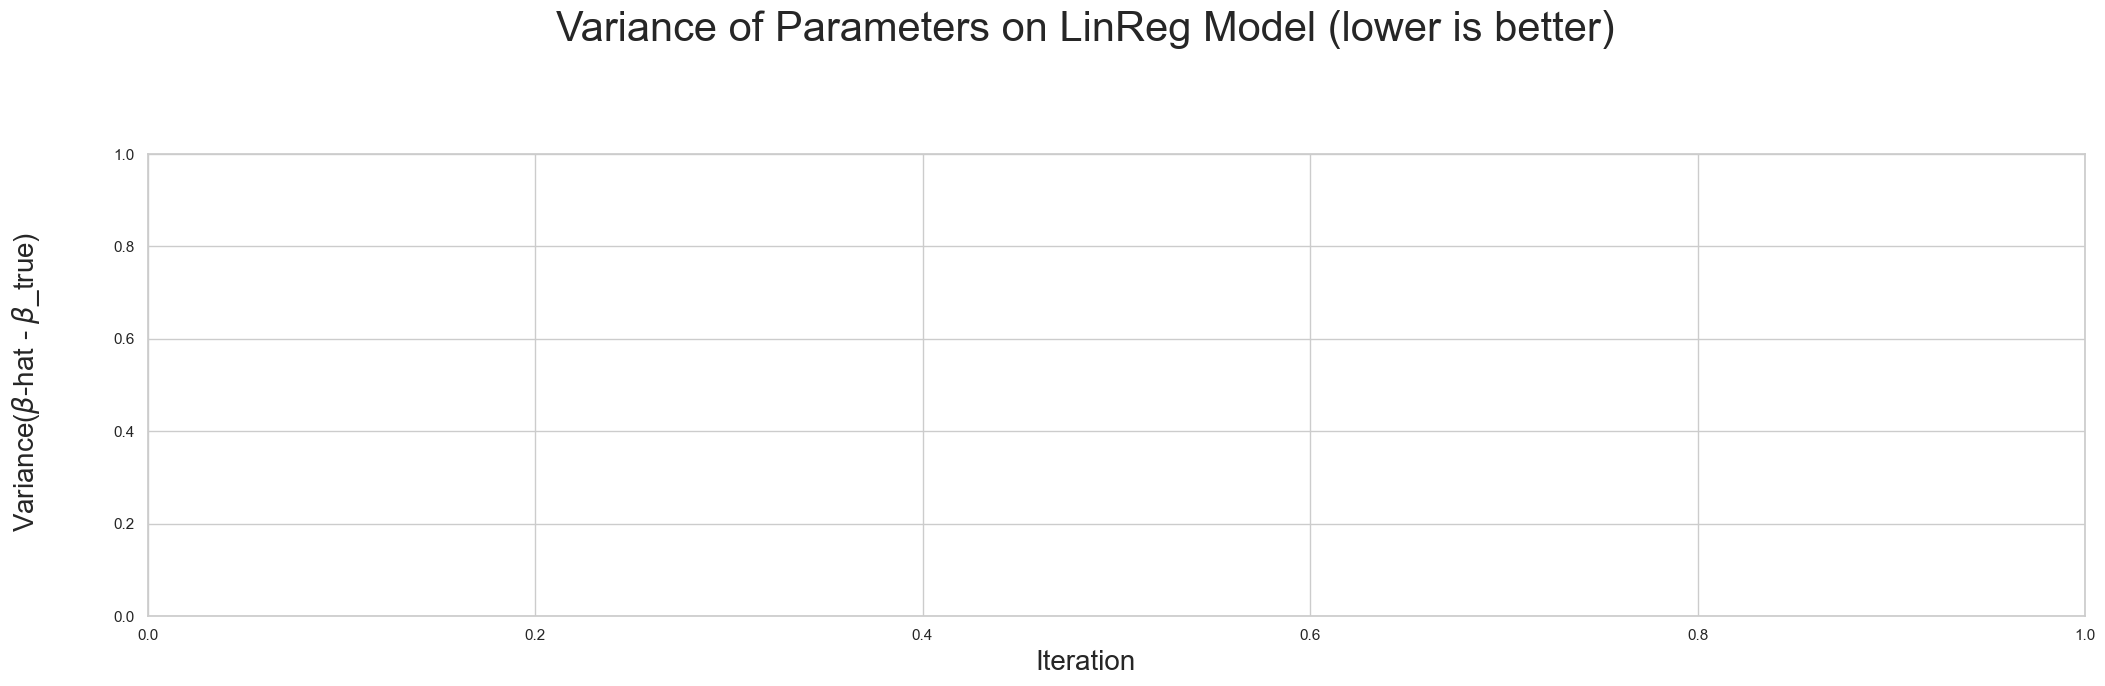

In [31]:
plot_sims(logscale=True, calc_gain=False)

/var/folders/m7/lkv5b4cx1bvggq9mr7cs4vbr0000gp/T/ipykernel_85426/3674030456.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  res = sns.lineplot(ax=ax, data=data, marker="o", lw=3, palette=line_palette)
/var/folders/m7/lkv5b4cx1bvggq9mr7cs4vbr0000gp/T/ipykernel_85426/3674030456.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  res = sns.lineplot(ax=ax, data=data, marker="o", lw=3, palette=line_palette)
/Users/p/.virtualenvs/data_sci/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


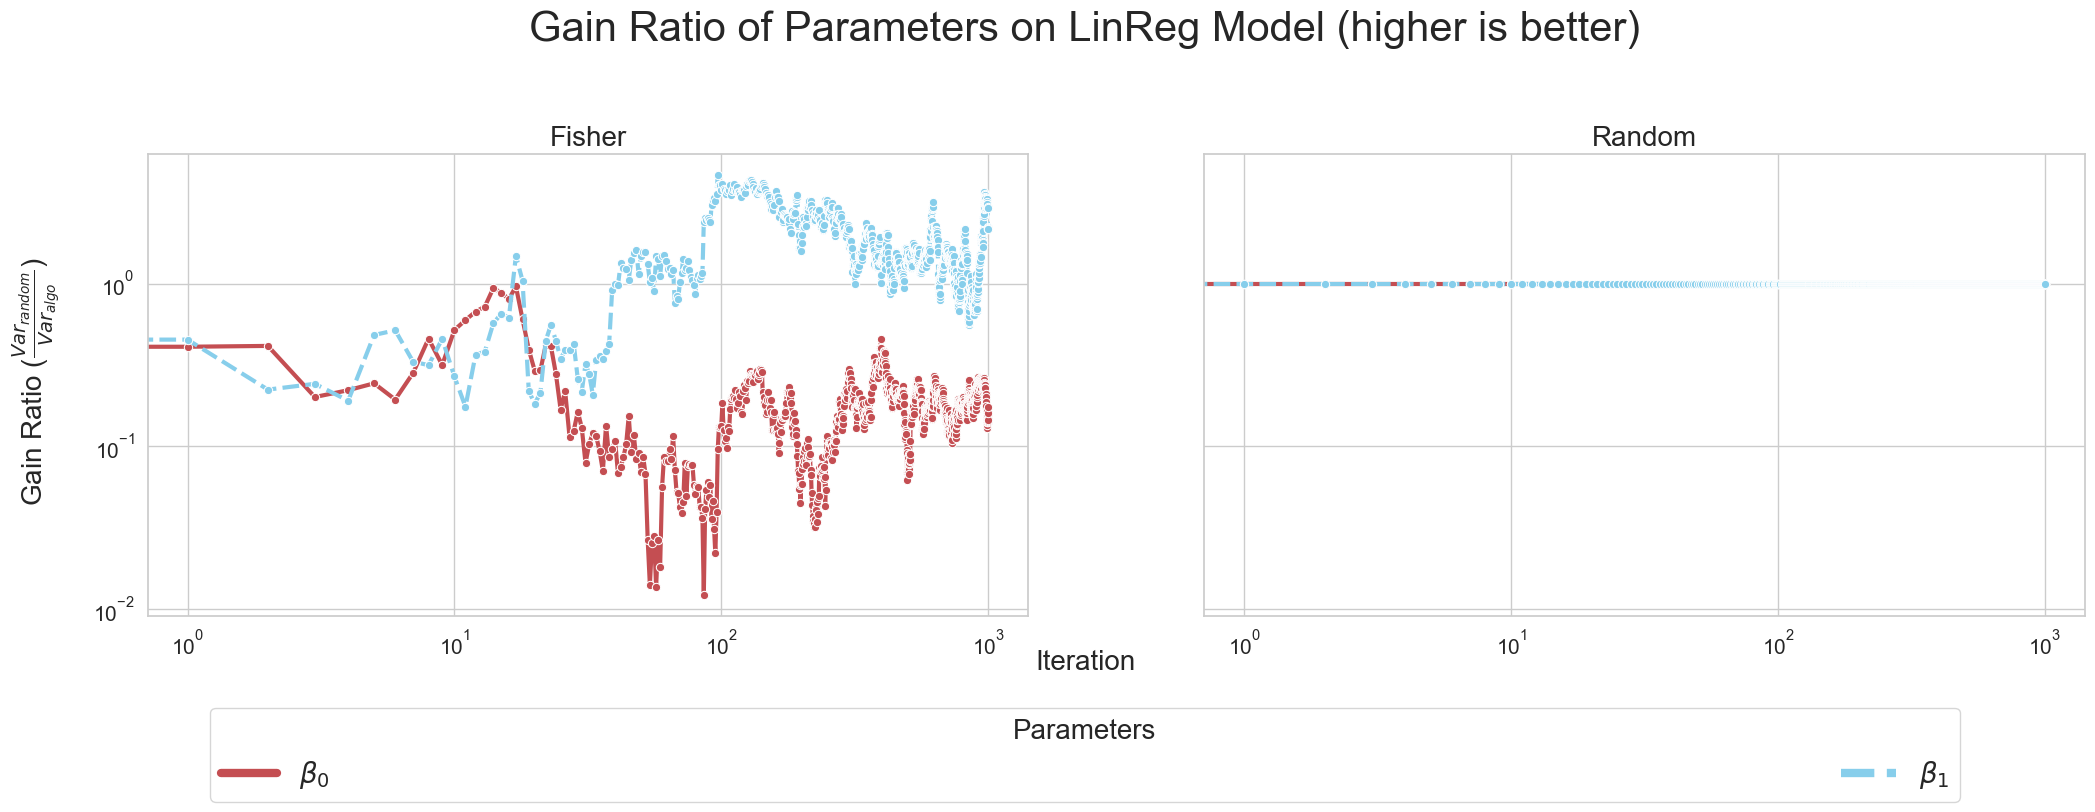

In [32]:
plot_sims(logscale=True, calc_gain=True)